# ResNetを組む
- [元論文 "Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385)
- まずは画像サイズ縮小のない単純なものから試す。

In [1]:
import numpy as np

f = np.load('mnist.npz')
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']

# 28 x 28ピクセルの画像を[0,1]に正規化
x_train = np.reshape(x_train, (60000, 28,28,1)) / 255.
x_test = np.reshape(x_test, (10000, 28,28,1)) / 255.

# one-hotベクトルに変換
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [2]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Flatten, Add, GlobalAveragePooling2D
from keras.models import Model

def res_block(x):
    Fh = Conv2D(32, (3,3), padding='same')(x)
    Fh = BatchNormalization()(Fh)
    Fh = Activation('relu')(Fh)
    
    Fh = Conv2D(32, (3,3), padding='same')(Fh)
    Fh = BatchNormalization()(Fh)
    Fh = Activation('relu')(Fh)

    h = Add()([x,Fh])
    return h

x = h = Input(shape=(28,28,1))

for _ in range(10):
    h = res_block(h)

h = GlobalAveragePooling2D()(h)

h = Dense(10)(h)
h = BatchNormalization()(h)
y = Activation('softmax')(h)

resnet = Model(inputs=x, outputs=y)

Using TensorFlow backend.


In [3]:
resnet.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc'],
)

In [4]:
resnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 28, 28, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [5]:
from keras.callbacks import ModelCheckpoint

check_pointer = ModelCheckpoint(
    filepath='best_weights_resnet.h5',
    monitor='val_acc',
    verbose=0, 
    mode='max'
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 2177s - loss: 0.3677 - acc: 0.9458 - val_loss: 0.5716 - val_acc: 0.8167
Epoch 2/20
54000/54000 [==============================] - 2163s - loss: 0.1436 - acc: 0.9745 - val_loss: 0.7509 - val_acc: 0.7845
Epoch 3/20
54000/54000 [==============================] - 2164s - loss: 0.0953 - acc: 0.9812 - val_loss: 0.4716 - val_acc: 0.8522
Epoch 4/20
54000/54000 [==============================] - 2163s - loss: 0.0732 - acc: 0.9839 - val_loss: 0.1466 - val_acc: 0.9608
Epoch 5/20
54000/54000 [==============================] - 2161s - loss: 0.0562 - acc: 0.9869 - val_loss: 0.2317 - val_acc: 0.9160
Epoch 6/20
54000/54000 [==============================] - 2162s - loss: 0.0453 - acc: 0.9893 - val_loss: 0.0989 - val_acc: 0.9772
Epoch 7/20
54000/54000 [==============================] - 2161s - loss: 0.0411 - acc: 0.9899 - val_loss: 0.5017 - val_acc: 0.8217
Epoch 8/20
54000/54000 [=================

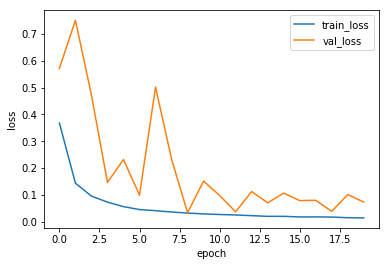

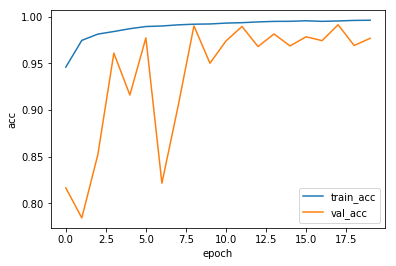

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

if True:
    hist = resnet.fit(
        x = x_train,
        y = y_train,
        epochs=20,
        validation_split=0.1,
        callbacks=[check_pointer],
    )

    plt.plot(hist.epoch, hist.history['loss'], label='train_loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    plt.plot(hist.epoch, hist.history['acc'], label='train_acc')
    plt.plot(hist.epoch, hist.history['val_acc'], label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
else:
    resnet.load_weights('best_weights_resnet.h5')

## Grad-CAMを表示する

In [16]:
def func_get_saliency(model, layer_idx):
    inp = model.layers[0].input
    outp = model.layers[-1].output
    midmap = model.layers[layer_idx].input
    saliency = K.gradients(K.max(outp,-1), midmap)
    return K.function(inputs=[inp, K.learning_phase()], outputs=saliency)

def func_get_activation(model, idx):
    inp = model.layers[0].input
    outp = model.layers[idx].output
    return K.function(inputs=[inp, K.learning_phase()], outputs=[outp])


In [17]:
import keras.backend as K

for i,layer in enumerate(resnet.layers):
    if layer.__class__.__name__=='GlobalAveragePooling2D':
        gap_idx = i

get_activation = func_get_activation(resnet, gap_idx-1)
get_saliency = func_get_saliency(resnet, gap_idx)

A_L = get_activation(([x_test, 0]))[0]
sal_test_gap = np.array(get_saliency([x_test, 0]))[0]
alpha_L = sal_test_gap.mean(1).mean(1)

gradCAMs = []
for A, alpha in zip(A_L, alpha_L):
    foo = (A*alpha).sum(-1)
    gradCAMs.append(foo*(foo>0)) # ReLUを掛ける
gradCAMs = np.array(gradCAMs)

In [18]:
nb_show = 10

y_pred_label = resnet.predict(x_test).argmax(axis=1)

x_label = []
gradCAMs_label = []
for label in range(10):
    x_label.append(x_test[(y_pred_label==label)][:nb_show])
    gradCAMs_label.append(gradCAMs[(y_pred_label==label)][:nb_show])
x_label = np.array(x_label).squeeze()
gradCAMs_label = np.array(gradCAMs_label).squeeze()

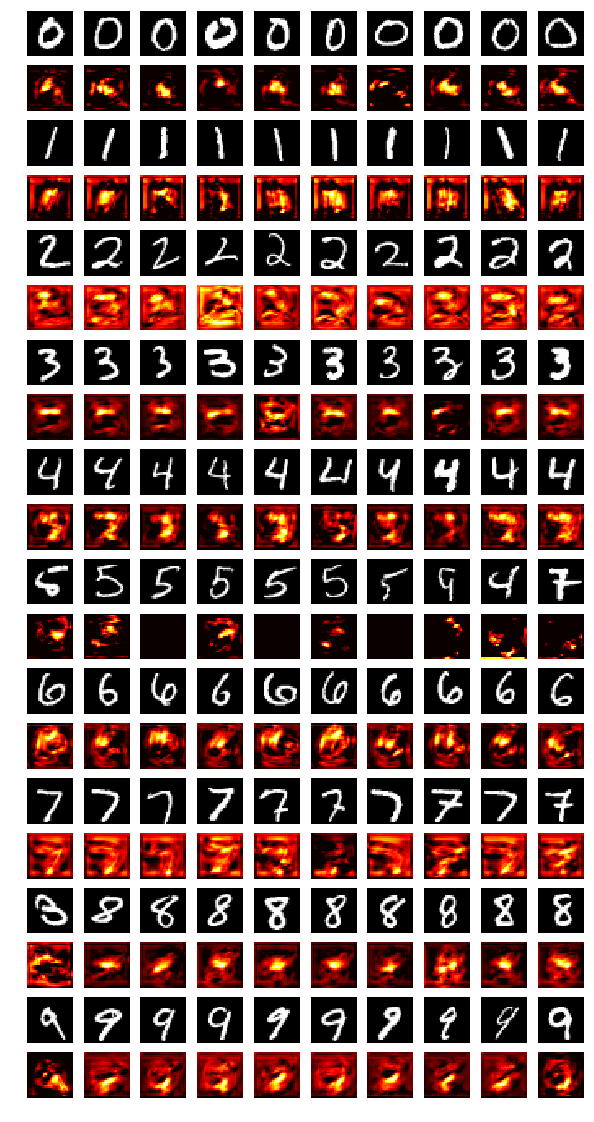

In [19]:
nb = 0
plt.figure(figsize=(10,int(10/nb_show*20)))
for x,g in zip(x_label, gradCAMs_label):
    for x2 in x:
        nb += 1
        plt.subplot(20,nb_show,nb)
        plt.imshow(x2, 'gray')
        plt.axis('off')
        
    for g2 in g:
        nb += 1
        plt.subplot(20,nb_show,nb)
        plt.imshow(g2, 'hot')
        plt.axis('off')